In [1]:
import matplotlib.pyplot as plt
import networkx as nx

# Load nodes and edges
G = nx.Graph()
G.add_nodes_from(list(range(1,12)))

edges = [
    (1, 2, {"weight": 2}),
    (1, 10, {"weight": 3}),
    (2, 4, {"weight": 7}),
    (2, 10, {"weight": 4}),
    (3, 5, {"weight": 4}),
    (3, 8, {"weight": 3}),    
    (3, 9, {"weight": 5}),
    (4, 8, {"weight": 5}),
    (4, 10, {"weight": 6}),
    (4, 12, {"weight": 3}),
    (5, 9, {"weight": 5}),
    (6, 7, {"weight": 5}),
    (6, 10, {"weight": 3}),
    (6, 11, {"weight": 4}),
    (7, 9, {"weight": 6}),
    (7, 11, {"weight": 2}),
    (8, 9, {"weight": 3}),
    (8, 12, {"weight": 1}),
    (9, 11, {"weight": 3}),
    (10, 12, {"weight": 1}),
    (11, 12, {"weight": 4}),
]

G.add_edges_from(edges)


In [2]:
pos = {
    1: (0, 2),
    2: (0, 3),
    3: (4, 2),
    4: (2, 3),
    5: (4, 1),
    6: (1, 1),
    7: (2, 0),
    8: (3, 2),
    9: (3, 1),
    10: (1, 2),
    11: (2, 1),
    12: (2, 2),
}

#node_colors = ["r" if n == "S" or n == "G" else "k" for n in list(G.nodes)]
#highlight_edges = list((zip(result[:-1], result[1:])))
#highlight_edges = [tuple(sorted(e)) for e in highlight_edges]
#edge_colors = ["r" if e in highlight_edges else "k" for e in list(G.edges)]
#edge_widths = [4 if e in highlight_edges else 1 for e in list(G.edges)]
labels = nx.get_edge_attributes(G, "weight")

# nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
# nx.draw_networkx(
#     G,
#     pos=pos,
#     font_color="w"
#     )
# """ node_color=node_colors,
#     ,
#     edge_color=edge_colors,
#     width=edge_widths,
# )"""
# plt.show()

In [3]:
shortcuts = {}
orig_G = G.copy()
shortest_paths = dict(nx.all_pairs_dijkstra_path_length(G, weight="weight"))
current_G = G.copy()
for node in G.nodes:
    current_G.remove_node(node)
    current_shortest_paths = dict(
        nx.all_pairs_dijkstra_path_length(current_G, weight="weight")
    )
    for u in current_shortest_paths:
        if u == node:
            continue
        SP_contracted = current_shortest_paths[u]
        SP_original = shortest_paths[u]
        for v in SP_contracted:
            if u == v or node == v:
                continue
            if (
                SP_contracted[v] != SP_original[v]
                and G.has_edge(node, u)
                and G.has_edge(node, v)
            ):
                G.add_edge(u, v, weight=SP_original[v], contracted=True)
                shortcuts[(u,v)] = node


In [4]:
from itertools import count
from heapq import heappush, heappop
from time import process_time
from optimization_algorithms_tools.structures import Solution
from sys import getsizeof

def _weight_function(G, weight):
    if callable(weight):
        return weight
    # If the weight keyword argument is not callable, we assume it is a
    # string representing the edge attribute containing the weight of
    # the edge.
    if G.is_multigraph():
        return lambda u, v, d: min(attr.get(weight, 1) for attr in d.values())
    return lambda u, v, data: data.get(weight, 1)

In [5]:
def bidirectional_dijkstra(G, source, target, hierarchy = None, weight="weight"):
    start_time = process_time()
    space_req = 0
    if source not in G or target not in G:
        msg = f"Either source {source} or target {target} is not in G"
        raise nx.NodeNotFound(msg)

    if source == target:
        return (0, [source])

    weight = _weight_function(G, weight)
    push = heappush
    pop = heappop
    # Init:  [Forward, Backward]
    dists = [{}, {}]  # dictionary of final distances
    paths = [{source: [source]}, {target: [target]}]  # dictionary of paths
    fringe = [[], []]  # heap of (distance, node) for choosing node to expand
    seen = [{source: 0}, {target: 0}]  # dict of distances to seen nodes
    c = count()
    # initialize fringe heap
    push(fringe[0], (0, next(c), source))
    push(fringe[1], (0, next(c), target))
    # neighs for extracting correct neighbor information
    if G.is_directed():
        neighs = [G._succ, G._pred]
    else:
        neighs = [G._adj, G._adj]
    # variables to hold shortest discovered path
    # finaldist = 1e30000
    finalpath = []
    dir = 1
    while fringe[0] and fringe[1]:
        # choose direction
        # dir == 0 is forward direction and dir == 1 is back
        dir = 1 - dir
        # extract closest to expand
        (dist, _, v) = pop(fringe[dir])
        if v in dists[dir]:
            # Shortest path to v has already been found
            continue
        # update distance
        dists[dir][v] = dist  # equal to seen[dir][v]
        if v in dists[1 - dir]:
            # if we have scanned v in both directions we are done
            # we have now discovered the shortest path
            end_time = process_time()
            return Solution(finalpath, end_time-start_time, space_req, len(seen[0])+len(seen[1]))

        for w, d in neighs[dir][v].items():
            # weight(v, w, d) for forward and weight(w, v, d) for back direction
            cost = weight(v, w, d) if dir == 0 else weight(w, v, d)
            if cost is None:
                continue
            vwLength = dists[dir][v] + cost
            if w not in seen[dir] or vwLength < seen[dir][w]:
                if hierarchy:
                    if hierarchy[v] > hierarchy[w]: continue
                
                # relaxing
                seen[dir][w] = vwLength
                push(fringe[dir], (vwLength, next(c), w))
                space_req = max(space_req, getsizeof(fringe))
                paths[dir][w] = paths[dir][v] + [w]
                if w in seen[0] and w in seen[1]:
                    # see if this path is better than the already
                    # discovered shortest path
                    totaldist = seen[0][w] + seen[1][w]
                    if finalpath == [] or finaldist > totaldist:
                        finaldist = totaldist
                        revpath = paths[1][w][:]
                        revpath.reverse()
                        finalpath = paths[0][w] + revpath[1:]
    raise nx.NetworkXNoPath(f"No path between {source} and {target}.")

In [6]:
hierarchy = {node: node for node in G.nodes}
sln_no_contract = bidirectional_dijkstra(orig_G, 1, 5, weight="weight")
sln = bidirectional_dijkstra(G, 1, 5, hierarchy, weight="weight")

uncontracted_route = [sln.result[0]]
for u, v in zip(sln.result[:-1], sln.result[1:]):
    if (u, v) in shortcuts:
        uncontracted_route.append(shortcuts[(u, v)])
    uncontracted_route.append(v)

print("Original vs. Contracted")
print(f"Time: {sln_no_contract.time} vs. {sln.time}")
print(f"Space: {sln_no_contract.space} vs. {sln.space}")
print(f"Explored Nodes: {sln_no_contract.explored} vs. {sln.explored}")


Original vs. Contracted
Time: 0.0 vs. 0.0
Space: 72 vs. 72
Explored Nodes: 16 vs. 11


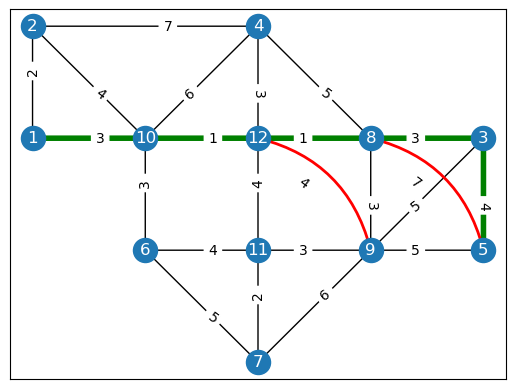

In [7]:
labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, label_pos=0.4, )
contracted_edges = nx.get_edge_attributes(G,"contracted")
ec = ["r" if edge in contracted_edges else "b" for edge in G.edges]
highlight_edges = list((zip(uncontracted_route[:-1], uncontracted_route[1:])))
highlight_edges = [tuple(t) for t in [sorted(e) for e in highlight_edges]]
edge_colors = ["r" if e in highlight_edges else "k" for e in list(G.edges)]
edge_widths = [4 if e in highlight_edges else 1 for e in list(G.edges)]

ax = plt.gca()
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_labels(G,pos, font_color='w')

# Draw each edges one at a time, modifying curvature by index
for e in G.edges:
    c = "red" if e in contracted_edges else "black"
    c = "green" if e in highlight_edges else c
    w = 2 if e in contracted_edges else 1
    w = 4 if e in highlight_edges else w
    curve = 1 if e in contracted_edges else 0
    zorder = 1 if e in contracted_edges else 0
    ax.annotate("",xy=pos[e[0]], xycoords='data', xytext=pos[e[1]], textcoords='data', color=c, arrowprops=dict(arrowstyle="-", connectionstyle=f"arc3, rad={-0.3*curve}", lw=w, color=c),zorder=zorder)

plt.show()